# Sprawozdanie z laboratorium 5

***Autorzy: Adam Dąbkowski, Yaroslav Harbar***

Celem piątego laboratorium jest zaimplementowanie perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej. Dodatkowo należy wytrenować zaimplementowany perceptron wielowarstwowy do klasyfikacji zbioru danych ***MNIST***.


## 0. Importowanie niezbędnych bibliotek

In [14]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## 1. Przygotowanie danych

Dane, na których będziemy testowali naszą implementację sieci neuronowych, a dokładniej perceptronu wielowarstwowego, jest zbiór ***MNIST***. Zbiór ten jest zbiorem obrazków przedstawiających odręcznie zapisane cyfry od ***0*** do ***9***. Aby go pobrać, wykorzystamy bibliotekę ***keras***.



In [ ]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

Aby móc pracować na trzech zbiorach (***treningowym***, ***walidacyjnym***, ***testowym***) konieczne jest połączenie obu powyższych zbiorów, co umożliwi ich wydzielenie w sposób losowy z otrzymanego zbioru.

In [4]:
X_data = np.concatenate((train_x, test_x), axis=0)
y_data = np.concatenate((train_y, test_y), axis=0)

In [6]:
print("X.shape: ", X_data.shape)
print("y.shape: ", y_data.shape)

X.shape:  (70000, 28, 28)
y.shape:  (70000,)


Wykorzystywany zbiór danych zawiera ***70000*** próbek. W przypadku danych z przestrzeni wejściowej ***X_data***, każda próbka ma wymiary ***28*** na ***28***. Przykładową reprezentację cyfry zamieszczono poniżej:

In [7]:
def plot_digit(data):
    plt.imshow(data, cmap="binary",
               interpolation="nearest")
    plt.axis("off")

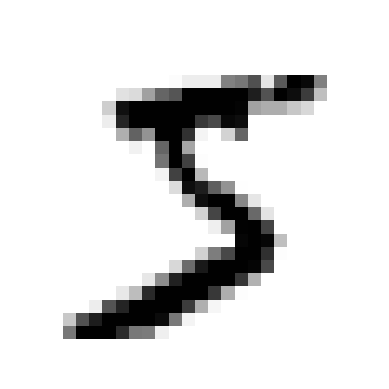

In [8]:
plot_digit(X_data[0])

Powyższa cyfra to prawdopodobnie cyfra ***5***. Aby to sprawdzić możemy wczytać pierwszy element z ***y_data***, zawierającego zbiór wyjść.

In [9]:
y_data[0]

5

Przed przystąpieniem do procesu trenowania konieczna jest także zmiana wymiarowości próbki (spłaszczenie wektorów).

In [10]:
X_data = X_data.reshape(X_data.shape[0], 784)

In [11]:
X_data.shape

(70000, 784)

Kolejnym krokiem jest normalizacja. Wykorzystujemy tutaj fakt, że maksymalna wartość pojedynczego piksela ma wartość ***255***.

In [12]:
X_data = X_data / 255

W przypadku klasyfikacji dla więcej niż ***2*** klas należy przeprowadzić kodowanie wyjść w sposób gorącojedynkowy (*one-hot encoding*), dzięki temu przypisanie zdjęcia do każdej z klas jest reprezentowane przez ***0***, gdy dana cyfra nie jest przypisana do danej klasy, lub przez ***1***, gdy dana klasa w sposób prawidłowy odzwieciedla cyfrę na obrazku.

In [15]:
onehot_encoder = OneHotEncoder(sparse=False)
y_data = onehot_encoder.fit_transform(y_data.reshape(y_data.shape[0], 1))

In [16]:
y_data[0:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Ostatnim krokiem jest podział ***X_data*** i ***y_data*** na zbiory: treningowy (*train*), walidacyjny (*val*) i testowy (*test*). Podczas podziału istotne są proporcje, w których utworzone zostaną nowe zbiory. Oczywiście większość danych powinniśmy przydzielić do zbioru treningowego, jednakże utworzenie zbyt małych zbiorów walidacyjnych i testowych może spowodować, że ocena modelu nie będzie odzwierciedlała jego faktycznej jakości, ponieważ o tym, czy dany model będzie dobry lub zły decydować będzie w głównej dobór elementów zawartych w zbiorach. Dlatego, aby się przed tym zabezpieczyć, nasz zbiór treningowy zawierał będzie **70%** danych, natomiast walidacyjny i testowy po **15%**.

In [17]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_data, y_data, train_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

## 2. Implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej

Głównym zadaniem czwartego laboratorium jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej. W tym celu stworzona została klasa ***NeuralNetwork***. Podczas tworzenia obiektu tej klasy istnieje możliwość podania parametrów ***layers*** (*lista zawierająca liczbę neuronów w poszczególnej warstwie*), ***epochs*** (*liczba epok*), ***learning_rate*** (*współczynnik uczenia*), ***activation_function*** (*funkcja aktywacji*) oraz ***activation_function_derivative*** (*pochodna funkcji aktywacji*).



Klasa ***NeuralNetwork*** zawiera także osiem metod:
- ***get_parameters()*** - metoda zwracająca wartości parametrów ***layers***, ***epochs*** oraz ***learning_rate***
- ***forward_propagation()*** - metoda odpowiadająca za propagacja w przód
- ***compute_loss()*** - metoda wyznaczająca koszt w danej iteracji
- ***back_propagation()*** - metoda odpowiadająca za propagacja wsteczną
- ***update_weights_and_bias()*** - metoda aktualizująca wagi i progi (*bias*)
- ***predict()*** - metoda odpowiedzialna za predykcję wszystkich dostarczonych elementów
- ***evaluate_on_set()*** - metoda odpowiedzialna za ocenę na podanym zbiorze
- ***fit()*** - metoda odpowiedzialna za trenowanie modelu

Aby nasza implementacja była uniwersalna, wykorzystywane funkcje aktywacji oraz ich pochodne są zdefiniowane poza klasą ***NeuralNetwork***. Poniżej zamieszona została funkcja ***sigmoid***, a także jej pochodna. Chcąc z nich skorzystać wystarczy podać je jako parametry podczas tworzenia obiektu klasy ***NeuralNetwork***.

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

In [19]:
class NeuralNetwork:
    def __init__(self, layers, epochs, learning_rate, activation_function, activation_function_derivative):
        self.layers = layers
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)]
        self.bias = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers)-1)]
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative

    def get_parameters(self):
        return {
            "layers": self.layers,
            "epochs": self.epochs,
            "learning_rate": self.learning_rate
        }

    def forward_propagation(self, x):
        a = []
        a.append(x)

        for i in range(len(self.layers)-1):
            z = np.dot(a[i], self.weights[i]) + self.bias[i]
            a.append(self.activation_function(z))

        return a

    def compute_loss(self, a, y):
        m = y.shape[0]
        loss = -(1 / m) * np.sum(y * np.log(a[-1]) + (1 - y) * (np.log(1 - a[-1])))
        return loss

    def back_propagation(self, a, y):
        dw = []
        db = []
        m = y.shape[0]

        dz = 2*(a[-1] - y)
        dw.append(np.dot(a[-2].T, dz) / m)
        db.append(np.sum(dz, axis=0, keepdims=True) / m)

        for i in range(len(self.layers)-2, 0, -1):
            dz = np.dot(dz, self.weights[i].T) * self.activation_function_derivative(a[i])
            dw.append(np.dot(a[i-1].T, dz) / m)
            db.append(np.sum(dz, axis=0, keepdims=True) / m)

        dw.reverse()
        db.reverse()

        return dw, db

    def update_weights_and_bias(self, dw, db):
        for i in range(len(self.layers)-1):
            self.weights[i] = self.weights[i] - self.learning_rate * dw[i]
            self.bias[i] = self.bias[i] - self.learning_rate * db[i]

    def predict(self, X):
        return self.forward_propagation(X)[-1]

    def evaluate_on_set(self, X, y, metric='accuracy'):
        y_pred = self.predict(X)
        y_pred_class = np.argmax(y_pred, axis=1)
        y_class = np.argmax(y, axis=1)

        if metric == 'f1_score':
            set_metric_score = f1_score(y_class, y_pred_class, average='micro')
        else:
            set_metric_score = accuracy_score(y_class, y_pred_class)

        return set_metric_score

    def fit(self, X_train, y_train, X_val=None, y_val=None, minibatch_size=32, metric='accuracy'):
        cost_list = []
        train_metric_score_history = []
        validation_metric_score_history = []
        m = X_train.shape[0]

        for n in range(self.epochs):
            shuffled_indices = np.random.permutation(m)
            X_shuffled = X_train[shuffled_indices]
            y_shuffled = y_train[shuffled_indices]

            epoch_cost = 0
            n_batches = 0
            for i in range(0, m, minibatch_size):
                X_batch = X_shuffled[i:i+minibatch_size]
                y_batch = y_shuffled[i:i+minibatch_size]

                a = self.forward_propagation(X_batch)

                cost = self.compute_loss(a, y_batch)

                dw, db = self.back_propagation(a, y_batch)

                self.update_weights_and_bias(dw, db)
                epoch_cost += cost
                n_batches += 1

            cost_list.append(epoch_cost/n_batches)

            train_metric_score = self.evaluate_on_set(X_train, y_train, metric=metric)
            train_metric_score_history.append(train_metric_score)

            if X_val is not None and y_val is not None:
                val_metric_score = self.evaluate_on_set(X_val, y_val, metric=metric)
                validation_metric_score_history.append(val_metric_score)
                print(f"Epoch {n+1}/{epochs}: train set {metric}: {train_metric_score}, validation set {metric}: {val_metric_score}, loss: {epoch_cost/n_batches}")
            else:
                print(f"Epoch {n+1}/{epochs}: train set {metric}: {train_metric_score}, loss: {epoch_cost/n_batches}")

        return cost_list, train_metric_score_history, validation_metric_score_history

Aby móc oceniać wytrenowany model, a także analizować wyniki otrzymywane w trakcie jego trenowania, zaimplementowana została funkcja ***plot_history()*** , która jest odpowiedzialna za tworzenie wykresów zawierających historię otrzymywanych wyników.

In [20]:
def plot_history(train_history, validation_history, cost_list, metric='accuracy'):
    # accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(train_history, linewidth=2, label="Training set")
    plt.xticks(np.arange(0, len(train_history)), np.arange(1, len(train_history) + 1))
    plt.locator_params(axis='x', nbins=10)
    plt.plot(validation_history, linewidth=2, label="Validation set")
    plt.xticks(np.arange(0, len(validation_history)), np.arange(1, len(validation_history) + 1))
    plt.locator_params(axis='x', nbins=10)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(str.title(metric), fontsize=12)
    plt.legend(loc="upper left", fontsize=10)
    plt.show()

    # cost
    plt.figure(figsize=(7, 5))
    plt.plot(cost_list)
    plt.xticks(np.arange(0, len(cost_list)), np.arange(1, len(cost_list) + 1))
    plt.locator_params(axis='x', nbins=10)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.show()

## 3. Zastosowanie algorytmu

Mając zaimplementowaną klasę ***NeuralNetwork*** oraz funkcję analizującą otrzymywane wyniki, możemy przejść do przeprowadzenia szeregu doświadczeń polegających na poszukiwaniu najlepszego modelu, który umożliwia uzyskanie najlepszej jakości predykcji na zbiorze testowym. Wybór najlepszego modelu jest powiązany z **wielkością sieci** (**liczby warstw i neuronów każdej warstwie**), **współczynnika uczenia**, **liczby epok** oraz **rozmiaru minigrupy** (*minibatch*). Nasze rozważania zostały przeprowadzone dla podziału, w którym zbiór treningowy zawiera **70%** danych, natomiast walidacyjny i testowy po **15%**.

W pierwszym rozważanym przez nas przypadku będziemy korzystać z sieci składającej się z **4** warstw, w tym **2** ukrytych. Pierwsza warstwa zawiera **784** neurony, co jest tożsame z wymiarem próbki, natomiast warstwa wyjściowa składa się z **10** neuronów, co odpowiada z kolei liczbie klas, do jakich możemy przyporządkować obrazek. Warstwy ukryte zawierają odpowiednio **120** i **60** neuronów. Współczynnik uczenia wynosić będzie **0,003**, natomiast sam proces uczenia będzie trwał **10** epok. Wykorzystywane podczas uczenia minigrupy będą składały się z **32** próbek. Metryką, którą wykorzystamy podczas oceny, będzie dokładność (**accuracy**).

In [110]:
layers = [784, 120, 60, 10]
epochs = 10
learning_rate = 0.003
minibatch_size = 32
metric = 'accuracy'

In [111]:
model_0 = NeuralNetwork(layers, epochs, learning_rate, sigmoid, sigmoid_derivative)

In [112]:
cost_list_0, train_history_0, validation_history_0 = model_0.fit(X_train, y_train, X_val, y_val, minibatch_size, metric=metric)

Epoch 1/10: train set accuracy: 0.37273469387755104, validation set accuracy: 0.3657142857142857, loss: 4.019141219192313
Epoch 2/10: train set accuracy: 0.4933673469387755, validation set accuracy: 0.48533333333333334, loss: 2.6588046554402287
Epoch 3/10: train set accuracy: 0.5654285714285714, validation set accuracy: 0.5574285714285714, loss: 2.2919148179390567
Epoch 4/10: train set accuracy: 0.6132448979591837, validation set accuracy: 0.6053333333333333, loss: 2.067643055976903
Epoch 5/10: train set accuracy: 0.6488571428571429, validation set accuracy: 0.6434285714285715, loss: 1.9072987108145918
Epoch 6/10: train set accuracy: 0.6775714285714286, validation set accuracy: 0.6708571428571428, loss: 1.7825612096685455
Epoch 7/10: train set accuracy: 0.6991632653061225, validation set accuracy: 0.6943809523809524, loss: 1.6813591775299896
Epoch 8/10: train set accuracy: 0.719204081632653, validation set accuracy: 0.7148571428571429, loss: 1.5965341889944862
Epoch 9/10: train set acc

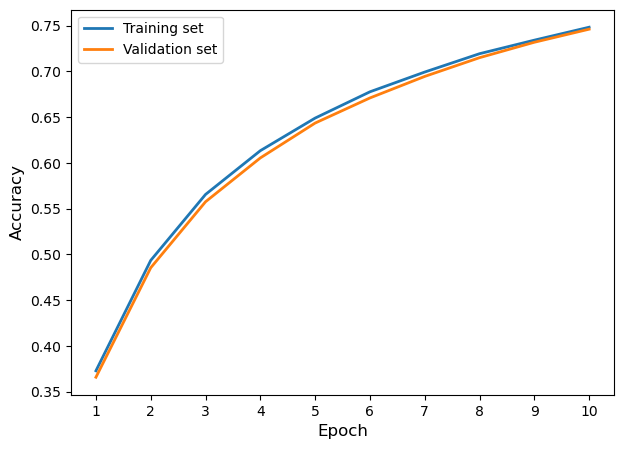

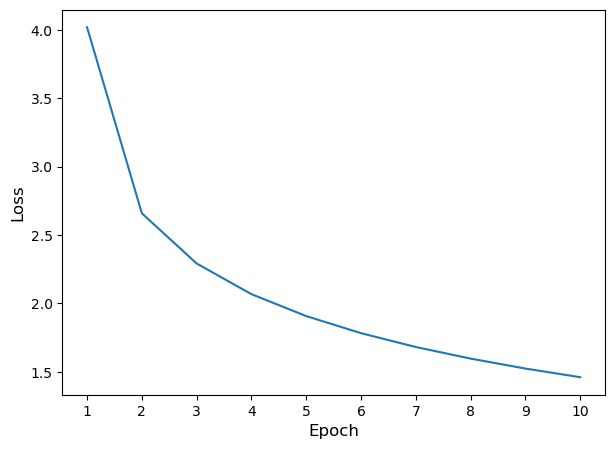

In [113]:
plot_history(train_history_0, validation_history_0, cost_list_0, metric=metric)

In [191]:
test_accuracy_0 = model_0.evaluate_on_set(X_test, y_test)
print(f"Test set {metric}: {test_accuracy_0}")

Test set accuracy: 0.7472380952380953


#### 3.1 Badanie wpływu liczby epok

Stosując jedynie **10** epok, uzyskaliśmy na zbiorze testowym dokładność wynoszącą w przybliżeniu **0,747238**. W przypadku zbioru MNIST nie jest to wartość zadowalająca. Jest to głównie spowodowane zbyt małą liczbą epok, dlatego sprawdźmy, co się stanie, gdy liczba ta zostanie zwiększona do **25**, czy rzeczywiście uzyskamy poprawę.

In [115]:
layers = [784, 120, 60, 10]
epochs = 25
learning_rate = 0.003
minibatch_size = 32
metric = 'accuracy'

In [116]:
model_1 = NeuralNetwork(layers, epochs, learning_rate, sigmoid, sigmoid_derivative)

In [117]:
cost_list_1, train_history_1, validation_history_1 = model_1.fit(X_train, y_train, X_val, y_val, minibatch_size, metric=metric)

Epoch 1/25: train set accuracy: 0.33108163265306123, validation set accuracy: 0.32257142857142856, loss: 4.139539136748241
Epoch 2/25: train set accuracy: 0.4700408163265306, validation set accuracy: 0.4565714285714286, loss: 2.749517442079074
Epoch 3/25: train set accuracy: 0.5477755102040817, validation set accuracy: 0.5354285714285715, loss: 2.365310861821729
Epoch 4/25: train set accuracy: 0.6053061224489796, validation set accuracy: 0.5928571428571429, loss: 2.113649074778492
Epoch 5/25: train set accuracy: 0.6445714285714286, validation set accuracy: 0.630095238095238, loss: 1.9306572408536504
Epoch 6/25: train set accuracy: 0.6728775510204081, validation set accuracy: 0.6621904761904762, loss: 1.7932376189891992
Epoch 7/25: train set accuracy: 0.694734693877551, validation set accuracy: 0.6848571428571428, loss: 1.6876908153685195
Epoch 8/25: train set accuracy: 0.7123469387755103, validation set accuracy: 0.703047619047619, loss: 1.6024605346994103
Epoch 9/25: train set accurac

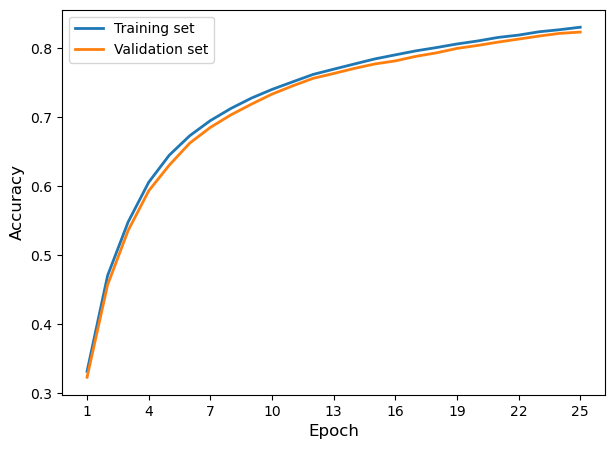

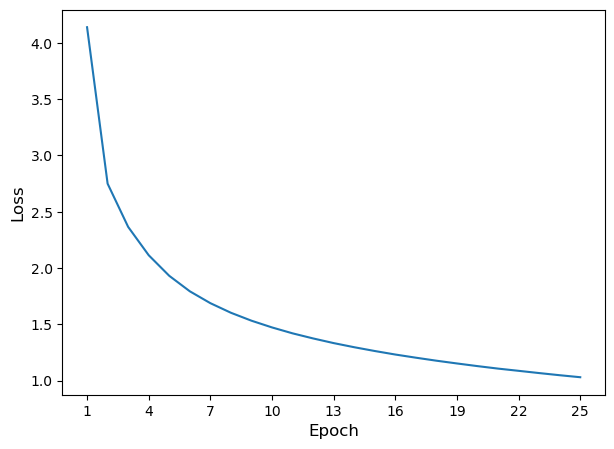

In [118]:
plot_history(train_history_1, validation_history_1, cost_list_1, metric=metric)

In [190]:
test_accuracy_1 = model_1.evaluate_on_set(X_test, y_test)
print(f"Test set {metric}: {test_accuracy_1}")

Test set accuracy: 0.8246666666666667


Widzimy, że na nasze przypuszczenia okazały się trafne, ponieważ otrzymana dokładność jest znacząco większa. Spróbujmy jeszcze zwiększyć liczbę epok w celu poprawy rezultatu, tym razem do wartości **100**.

In [120]:
layers = [784, 120, 60, 10]
epochs = 100
learning_rate = 0.003
minibatch_size = 32
metric = 'accuracy'

In [121]:
model_2 = NeuralNetwork(layers, epochs, learning_rate, sigmoid, sigmoid_derivative)

In [122]:
cost_list_2, train_history_2, validation_history_2 = model_2.fit(X_train, y_train, X_val, y_val, minibatch_size, metric=metric)

Epoch 1/100: train set accuracy: 0.3729387755102041, validation set accuracy: 0.37057142857142855, loss: 4.054345624550707
Epoch 2/100: train set accuracy: 0.5104693877551021, validation set accuracy: 0.5095238095238095, loss: 2.596499584447611
Epoch 3/100: train set accuracy: 0.5868775510204082, validation set accuracy: 0.587047619047619, loss: 2.195139789418744
Epoch 4/100: train set accuracy: 0.6362448979591837, validation set accuracy: 0.6365714285714286, loss: 1.9670531596859273
Epoch 5/100: train set accuracy: 0.6714489795918367, validation set accuracy: 0.6731428571428572, loss: 1.808422965809043
Epoch 6/100: train set accuracy: 0.698530612244898, validation set accuracy: 0.6992380952380952, loss: 1.687488840832567
Epoch 7/100: train set accuracy: 0.720265306122449, validation set accuracy: 0.7192380952380952, loss: 1.590315194634049
Epoch 8/100: train set accuracy: 0.7373469387755102, validation set accuracy: 0.7363809523809524, loss: 1.5104858249364346
Epoch 9/100: train set a

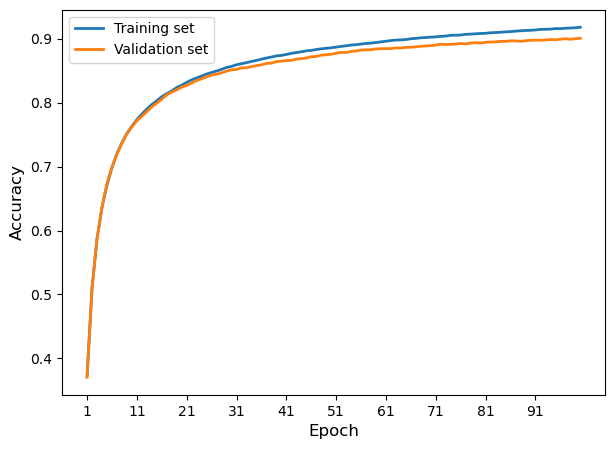

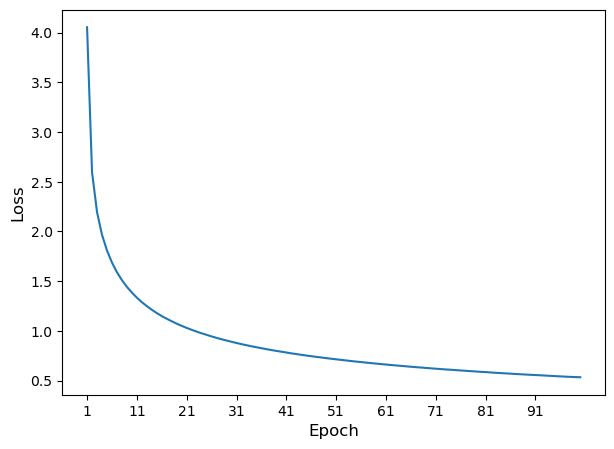

In [123]:
plot_history(train_history_2, validation_history_2, cost_list_2, metric=metric)

In [189]:
test_accuracy_2 = model_2.evaluate_on_set(X_test, y_test)
print(f"Test set {metric}: {test_accuracy_2}")

Test set accuracy: 0.9038095238095238


Po raz kolejny uzyskaliśmy poprawę, tym razem w każdym z rozpatrywanych zbiorów dokładność przekroczyła **90%**, co stanowi dobry wynik.


#### 3.2 Badanie wpływu wartości współczynnika uczenia

W analizowanym uprzednio przykładzie, gdy przyjrzymy się historii wyników, możemy dostrzec, że przyrost dokładności modelu jest stosunkowo mały (mając na uwadze liczbę epok). Jest to spowodowane zbyt małym współczynnikiem uczenia. Dlatego, aby zwiększyć przyrost dokładność w kolejnym doświadczeniu współczynnik uczenia zostanie zwiększony do wartości **0,01**.

In [125]:
layers = [784, 120, 60, 10]
epochs = 100
learning_rate = 0.01
minibatch_size = 32
metric = 'accuracy'

In [126]:
model_3 = NeuralNetwork(layers, epochs, learning_rate, sigmoid, sigmoid_derivative)

In [127]:
cost_list_3, train_history_3, validation_history_3 = model_3.fit(X_train, y_train, X_val, y_val, minibatch_size, metric=metric)

Epoch 1/100: train set accuracy: 0.5545102040816327, validation set accuracy: 0.5566666666666666, loss: 3.0648690876341025
Epoch 2/100: train set accuracy: 0.6809591836734694, validation set accuracy: 0.6777142857142857, loss: 1.917536938940509
Epoch 3/100: train set accuracy: 0.7391224489795918, validation set accuracy: 0.732, loss: 1.5821624294644483
Epoch 4/100: train set accuracy: 0.7744489795918368, validation set accuracy: 0.7673333333333333, loss: 1.3848835312871697
Epoch 5/100: train set accuracy: 0.7989591836734694, validation set accuracy: 0.791047619047619, loss: 1.2494597042456244
Epoch 6/100: train set accuracy: 0.818734693877551, validation set accuracy: 0.808, loss: 1.1488565647353004
Epoch 7/100: train set accuracy: 0.8301836734693877, validation set accuracy: 0.8182857142857143, loss: 1.0699107549590494
Epoch 8/100: train set accuracy: 0.8427755102040816, validation set accuracy: 0.833047619047619, loss: 1.0052982437690878
Epoch 9/100: train set accuracy: 0.85171428571

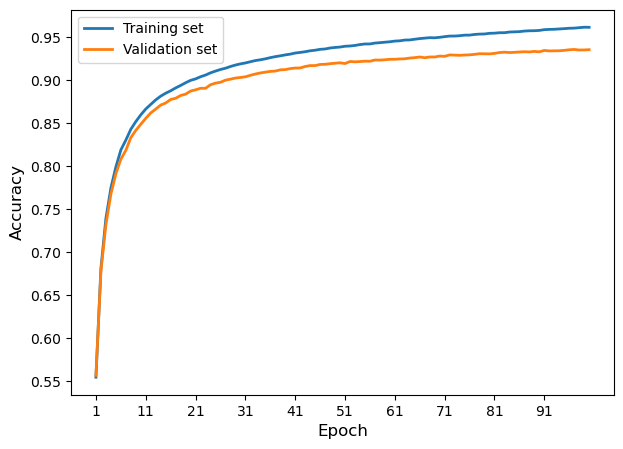

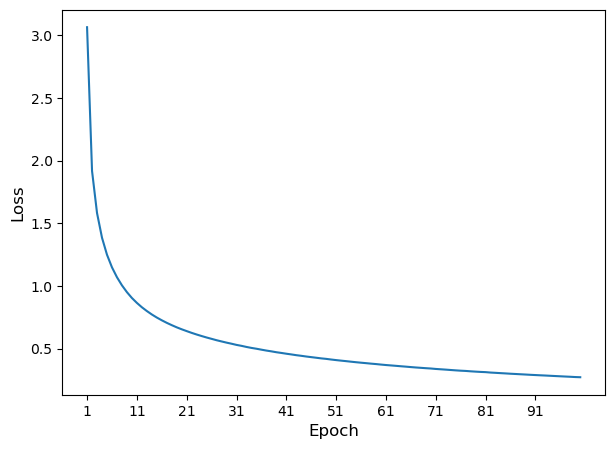

In [128]:
plot_history(train_history_3, validation_history_3, cost_list_3, metric=metric)

In [188]:
test_accuracy_3 = model_3.evaluate_on_set(X_test, y_test)
print(f"Test set {metric}: {test_accuracy_3}")

Test set accuracy: 0.9365714285714286


Dokładność w zbiorze treningowym, walidacyjnym, jak i testowym przekroczyła **93%**, co jest rezultatem bardzo dobrym. Spróbujmy, jednakże jeszcze raz zwiększyć współczynnik uczenia, tym razem do wartości **0,05**.

In [130]:
layers = [784, 120, 60, 10]
epochs = 100
learning_rate = 0.05
minibatch_size = 32
metric = 'accuracy'

In [131]:
model_4 = NeuralNetwork(layers, epochs, learning_rate, sigmoid, sigmoid_derivative)

In [132]:
cost_list_4, train_history_4, validation_history_4 = model_4.fit(X_train, y_train, X_val, y_val, minibatch_size, metric=metric)

Epoch 1/100: train set accuracy: 0.8073469387755102, validation set accuracy: 0.799047619047619, loss: 1.774604140368369
Epoch 2/100: train set accuracy: 0.8618979591836735, validation set accuracy: 0.8531428571428571, loss: 0.9907293402576394
Epoch 3/100: train set accuracy: 0.8835102040816326, validation set accuracy: 0.8720952380952381, loss: 0.8051523218217249
Epoch 4/100: train set accuracy: 0.8979591836734694, validation set accuracy: 0.8877142857142857, loss: 0.7036575665252026
Epoch 5/100: train set accuracy: 0.9090612244897959, validation set accuracy: 0.8965714285714286, loss: 0.6331659397310909
Epoch 6/100: train set accuracy: 0.9159183673469388, validation set accuracy: 0.902, loss: 0.5808921045859898
Epoch 7/100: train set accuracy: 0.921734693877551, validation set accuracy: 0.9078095238095238, loss: 0.5403591776491592
Epoch 8/100: train set accuracy: 0.9264897959183673, validation set accuracy: 0.912, loss: 0.5071599325282313
Epoch 9/100: train set accuracy: 0.9313469387

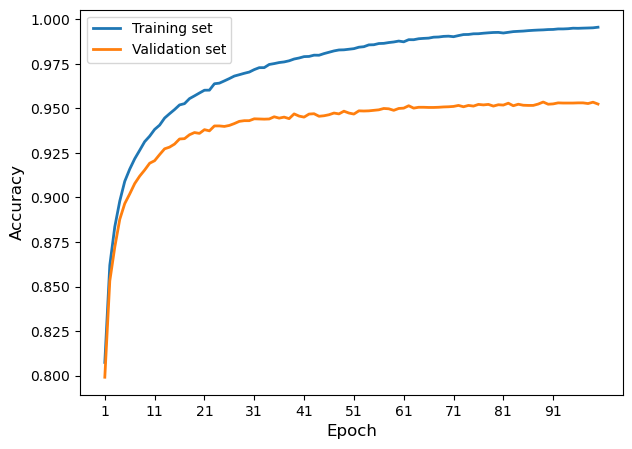

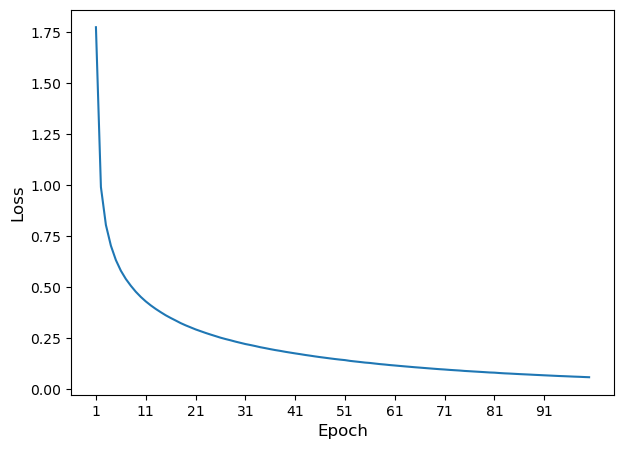

In [133]:
plot_history(train_history_4, validation_history_4, cost_list_4, metric=metric)

In [187]:
test_accuracy_4 = model_4.evaluate_on_set(X_test, y_test)
print(f"Test set {metric}: {test_accuracy_4}")

Test set accuracy: 0.9525714285714286


Otrzymane wyniki są rewelacyjne. Dokładność zarówno na zbiorze testowym, jak i walidacyjnym przekroczyła **95%**, natomiast w przypadku zbioru treningowego wynosi ponad **99,5%**, co jest równoznaczne z praktycznie idealnym rozpoznawaniem odręcznie zapisanych cyfr.

#### 3.3 Badanie wpływu wielkości (złożoności) sieci neuronowej

W następnym z rozważanych przypadków, zamiast zwiększać liczbę epok, bądź współczynnik uczenia, zmieniona zostanie struktura samej sieci. Tym razem zamiast **2** warstw ukrytych wykorzystamy **3**, które zawierają odpowiednio **200** , **120** oraz **60** neuronów. Taka modyfikacja powinna jeszcze bardziej przybliżyć nas do idealnego rozpoznawania cyfr.

In [135]:
layers = [784, 200, 120, 60, 10]
epochs = 100
learning_rate = 0.05
minibatch_size = 32
metric = 'accuracy'

In [136]:
model_5 = NeuralNetwork(layers, epochs, learning_rate, sigmoid, sigmoid_derivative)

In [137]:
cost_list_5, train_history_5, validation_history_5 = model_5.fit(X_train, y_train, X_val, y_val, minibatch_size, metric=metric)

Epoch 1/100: train set accuracy: 0.8015510204081633, validation set accuracy: 0.7979047619047619, loss: 1.9117936362672752
Epoch 2/100: train set accuracy: 0.8627142857142858, validation set accuracy: 0.856, loss: 1.0018197914687592
Epoch 3/100: train set accuracy: 0.8868775510204082, validation set accuracy: 0.8778095238095238, loss: 0.7683019460340984
Epoch 4/100: train set accuracy: 0.9073877551020408, validation set accuracy: 0.8949523809523809, loss: 0.645881917325741
Epoch 5/100: train set accuracy: 0.9182653061224489, validation set accuracy: 0.9028571428571428, loss: 0.5649329498790739
Epoch 6/100: train set accuracy: 0.9232857142857143, validation set accuracy: 0.9053333333333333, loss: 0.508207105151849
Epoch 7/100: train set accuracy: 0.9341224489795918, validation set accuracy: 0.9139047619047619, loss: 0.4618810200770239
Epoch 8/100: train set accuracy: 0.9403265306122449, validation set accuracy: 0.9164761904761904, loss: 0.4239314893116562
Epoch 9/100: train set accuracy

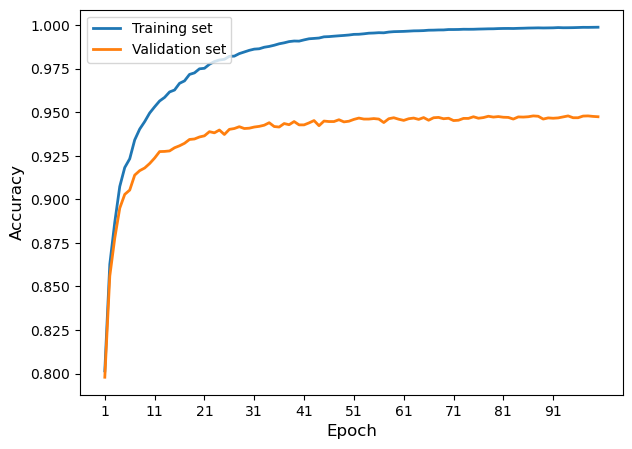

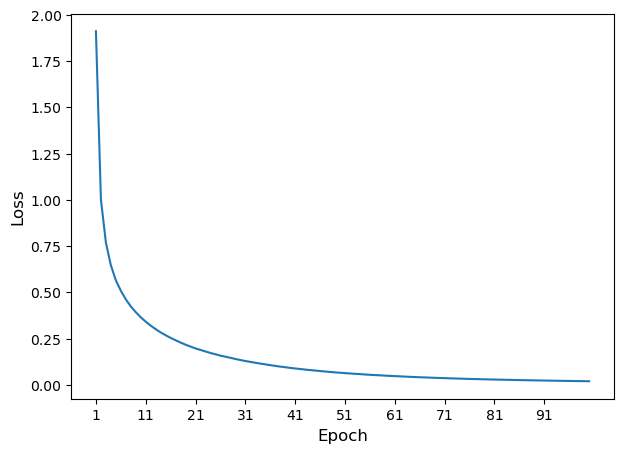

In [138]:
plot_history(train_history_5, validation_history_5, cost_list_5, metric=metric)

In [186]:
test_accuracy_5 = model_5.evaluate_on_set(X_test, y_test)
print(f"Test set {metric}: {test_accuracy_5}")

Test set accuracy: 0.944952380952381


Otrzymane wyniki są praktycznie identyczne, jednakże warto zauważyć, że dokładność na zbiorze treningowym jest minimalnie większa, natomiast dokładności na pozostałych minimalnie się zmniejszyły. W związku z tym, że różnice są bardzo małe, ciężko mówić o istotnym przetrenowaniu, jednakże możemy zauważyć, że w przypadku zmodyfikowanej sieci szybciej osiągamy coraz wyższe dokładności na zbiorze treningowym, w porównaniu do sieci wcześniej wykorzystywanej, przy jednoczesnym uzyskiwaniu coraz mniejszych kosztów.

Mając to na uwadze, sprawdźmy, czy korzystając z sieci o znacznie mniejszych rozmiarach, uzyskamy wyraźnie gorsze wyniki.

In [140]:
layers = [784, 48, 24, 10]
epochs = 100
learning_rate = 0.05
minibatch_size = 32
metric = 'accuracy'

In [141]:
model_6 = NeuralNetwork(layers, epochs, learning_rate, sigmoid, sigmoid_derivative)

In [142]:
cost_list_6, train_history_6, validation_history_6 = model_6.fit(X_train, y_train, X_val, y_val, minibatch_size, metric=metric)

Epoch 1/100: train set accuracy: 0.7209795918367347, validation set accuracy: 0.7100952380952381, loss: 2.1289796875143847
Epoch 2/100: train set accuracy: 0.8144285714285714, validation set accuracy: 0.8080952380952381, loss: 1.3174677284708545
Epoch 3/100: train set accuracy: 0.8506122448979592, validation set accuracy: 0.8441904761904762, loss: 1.0096788675150634
Epoch 4/100: train set accuracy: 0.8719795918367347, validation set accuracy: 0.8663809523809524, loss: 0.8438280148909711
Epoch 5/100: train set accuracy: 0.8885102040816326, validation set accuracy: 0.8784761904761905, loss: 0.7408252552570362
Epoch 6/100: train set accuracy: 0.8981428571428571, validation set accuracy: 0.8892380952380953, loss: 0.6706320274682098
Epoch 7/100: train set accuracy: 0.9061224489795918, validation set accuracy: 0.8954285714285715, loss: 0.619158482301814
Epoch 8/100: train set accuracy: 0.9126938775510204, validation set accuracy: 0.9001904761904762, loss: 0.5791490995767594
Epoch 9/100: trai

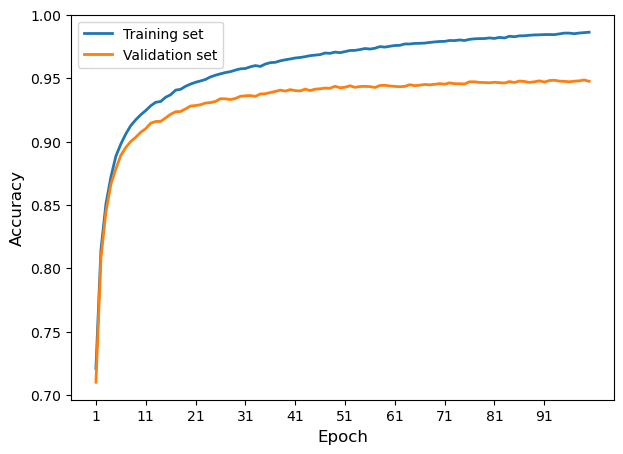

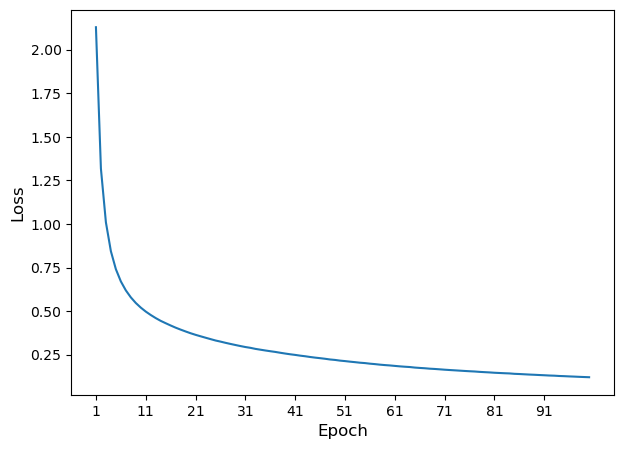

In [143]:
plot_history(train_history_6, validation_history_6, cost_list_6, metric=metric)

In [185]:
test_accuracy_6 = model_6.evaluate_on_set(X_test, y_test)
print(f"Test set {metric}: {test_accuracy_6}")

Test set accuracy: 0.9440952380952381


Jak widać powyżej, zastosowanie mniejszej sieci nie wpłynęło znacząco na otrzymaną dokładność na (szczególnie nas interesującym), zbiorze testowym, która jest praktycznie tożsama z tą uzyskaną dla sieci znacznie powiększonej. Oczywiście dokładność na zbiorze treningowym uległa minimalnemu pogorszeniu, jednakże o tym, czy model rzeczywiście dobrze spełnia swoje zadanie, decyduje dokładność uzyskana właśnie na zbiorze testowym.

#### 3.4 Badanie wpływu wielkości minigrupy

Przedmiotem kolejnych doświadczeń jest wpływ wielkości minigrupy wykorzystywanej podczas trenowania modelu. W dotychczasowo rozpatrywanych przypadkach wielkość ta wynosiła **32**. Tym razem zostanie zmniejszona do **16**, co powinno znacznie przyspieszyć proces nauki, jednakże może się zdarzyć, że przebieg algorytmu w przestrzeni parametrycznej może stać się bardziej chaotyczny.

In [145]:
layers = [784, 120, 60, 10]
epochs = 100
learning_rate = 0.05
minibatch_size = 16
metric = 'accuracy'

In [146]:
model_7 = NeuralNetwork(layers, epochs, learning_rate, sigmoid, sigmoid_derivative)

In [147]:
cost_list_7, train_history_7, validation_history_7 = model_7.fit(X_train, y_train, X_val, y_val, minibatch_size, metric=metric)

Epoch 1/100: train set accuracy: 0.8581836734693877, validation set accuracy: 0.8506666666666667, loss: 1.4237141526008725
Epoch 2/100: train set accuracy: 0.8988367346938776, validation set accuracy: 0.8890476190476191, loss: 0.7694482935323885
Epoch 3/100: train set accuracy: 0.9164897959183673, validation set accuracy: 0.9056190476190477, loss: 0.612349414366996
Epoch 4/100: train set accuracy: 0.9265714285714286, validation set accuracy: 0.9151428571428571, loss: 0.5236231725268508
Epoch 5/100: train set accuracy: 0.937204081632653, validation set accuracy: 0.9195238095238095, loss: 0.4623291613688301
Epoch 6/100: train set accuracy: 0.9427755102040817, validation set accuracy: 0.9257142857142857, loss: 0.4173331155129777
Epoch 7/100: train set accuracy: 0.9471632653061225, validation set accuracy: 0.9278095238095239, loss: 0.38090131311066106
Epoch 8/100: train set accuracy: 0.9521632653061225, validation set accuracy: 0.9336190476190476, loss: 0.35213435853847913
Epoch 9/100: tra

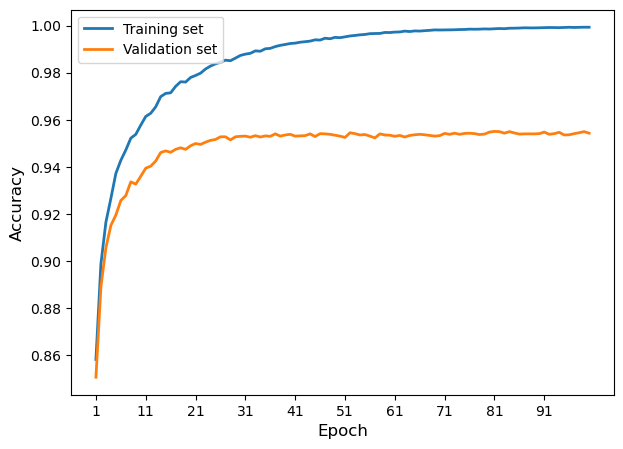

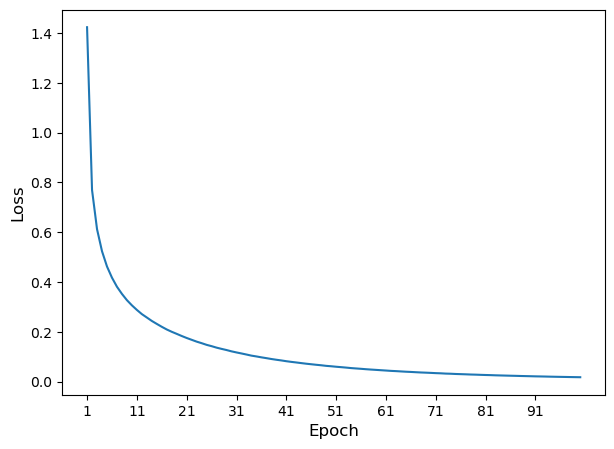

In [148]:
plot_history(train_history_7, validation_history_7, cost_list_7, metric=metric)

In [184]:
test_accuracy_7 = model_7.evaluate_on_set(X_test, y_test)
print(f"Test set {metric}: {test_accuracy_7}")

Test set accuracy: 0.9520952380952381


Dokładność na zbiorze treningowym przekroczyła **99,92%** co jest, jak dotąd, najlepszą uzyskaną wartością. Również w przypadku zbioru testowego, jak i walidacyjnego dokładność należy do najwyższych i przekracza **95%**, przez co zabieg polegający na zmniejszeniu rozmiaru minigrup znajduje swoje uzasadnienie. Sprawdźmy, czy zwiększenie rozmiaru do **128** spowoduje spadek uzyskiwanych dokładności.

In [150]:
layers = [784, 120, 60, 10]
epochs = 100
learning_rate = 0.05
minibatch_size = 128
metric = 'accuracy'

In [151]:
model_8 = NeuralNetwork(layers, epochs, learning_rate, sigmoid, sigmoid_derivative)

In [152]:
cost_list_8, train_history_8, validation_history_8 = model_8.fit(X_train, y_train, X_val, y_val, minibatch_size, metric=metric)

Epoch 1/100: train set accuracy: 0.6138571428571429, validation set accuracy: 0.6078095238095238, loss: 2.770916878030866
Epoch 2/100: train set accuracy: 0.7196734693877551, validation set accuracy: 0.7189523809523809, loss: 1.7357729304421086
Epoch 3/100: train set accuracy: 0.7732040816326531, validation set accuracy: 0.7734285714285715, loss: 1.4296065612182285
Epoch 4/100: train set accuracy: 0.8020204081632653, validation set accuracy: 0.7983809523809524, loss: 1.255985366211968
Epoch 5/100: train set accuracy: 0.821734693877551, validation set accuracy: 0.8148571428571428, loss: 1.1366929185317738
Epoch 6/100: train set accuracy: 0.8359183673469388, validation set accuracy: 0.8262857142857143, loss: 1.0466815006892496
Epoch 7/100: train set accuracy: 0.8470816326530612, validation set accuracy: 0.8376190476190476, loss: 0.9767569820292743
Epoch 8/100: train set accuracy: 0.8556734693877551, validation set accuracy: 0.8467619047619047, loss: 0.9193907590708554
Epoch 9/100: train 

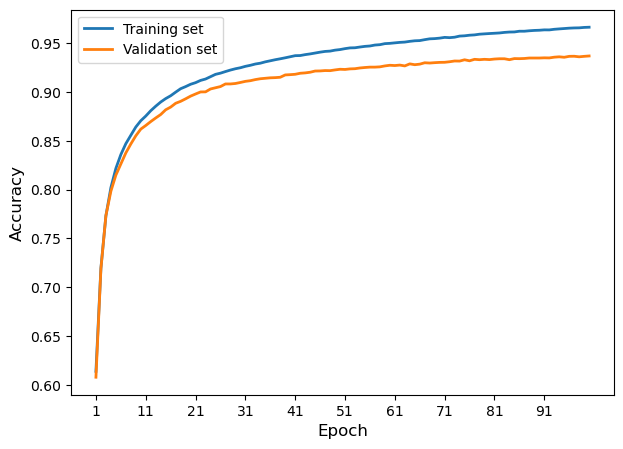

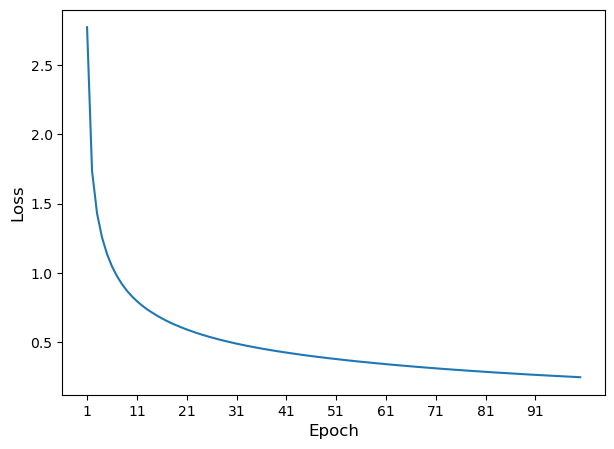

In [153]:
plot_history(train_history_8, validation_history_8, cost_list_8, metric=metric)

In [183]:
test_accuracy_8 = model_8.evaluate_on_set(X_test, y_test)
print(f"Test set {metric}: {test_accuracy_8}")

Test set accuracy: 0.9363809523809524


Dla każdego z rozpatrywanych zbiorów odnotowaliśmy znaczący spadek dokładności.

## 4. Podsumowanie

Dla zwiększenia czytelności otrzymanych rezultatów, poniżej została zamieszczona zbiorcza tabela, która przedstawia wyniki powyższych doświadczeń, a także sposób jej utworzenia.

In [204]:
epochs_data = [10, 25, 100, 100, 100, 100, 100, 100, 100]
layers_data = [[784, 120, 60, 10], [784, 120, 60, 10], [784, 120, 60, 10], [784, 120, 60, 10], [784, 120, 60, 10], [784, 200, 120, 60, 10], [784, 48, 24, 10], [784, 120, 60, 10], [784, 120, 60, 10]]
learning_rate_data = [0.003, 0.003, 0.003, 0.01, 0.05, 0.05, 0.05, 0.05, 0.05]
minibatch_size_data = [32, 32, 32, 32, 32, 32, 32, 16, 128]

loss_data = [cost_list_0[-1]] + [cost_list_1[-1]] + [cost_list_2[-1]] + [cost_list_3[-1]] + [cost_list_4[-1]] + [cost_list_5[-1]] + [cost_list_6[-1]] + [cost_list_7[-1]] + [cost_list_8[-1]]

train_accuracy_data = [train_history_0[-1]] + [train_history_1[-1]] + [train_history_2[-1]] + [train_history_3[-1]] + [train_history_4[-1]] + [train_history_5[-1]] + [train_history_6[-1]] + [train_history_7[-1]] + [train_history_8[-1]]

validation_accuracy_data = [validation_history_0[-1]] + [validation_history_1[-1]] + [validation_history_2[-1]] + [validation_history_3[-1]] + [validation_history_4[-1]] + [validation_history_5[-1]] + [validation_history_6[-1]] + [validation_history_7[-1]] + [validation_history_8[-1]]

test_accuracy_data = [test_accuracy_0] + [test_accuracy_1] + [test_accuracy_2] + [test_accuracy_3] + [test_accuracy_4] + [test_accuracy_5] + [test_accuracy_6] + [test_accuracy_7] + [test_accuracy_8]

In [205]:
data = {
    "Layers": layers_data,
    "Epochs": epochs_data,
    "Learning rate": learning_rate_data,
    "Minibatch size": minibatch_size_data,
    "Loss (last epoch)": loss_data,
    "Accuracy (train set)": train_accuracy_data,
    "Accuracy (validation set)": validation_accuracy_data,
    "Accuracy (test set)": test_accuracy_data
}
results = pd.DataFrame(data)

In [206]:
results

,Layers,Epochs,Learning rate,Minibatch size,Loss (last epoch),Accuracy (train set),Accuracy (validation set),Accuracy (test set)
0,"[784, 120, 60, 10]",10,0.003,32,1.460511,0.748143,0.746000,0.747238
1,"[784, 120, 60, 10]",25,0.003,32,1.029708,0.830163,0.823143,0.824667
2,"[784, 120, 60, 10]",100,0.003,32,0.534158,0.917959,0.900762,0.903810
3,"[784, 120, 60, 10]",100,0.010,32,0.271883,0.961367,0.935333,0.936571
4,"[784, 120, 60, 10]",100,0.050,32,0.058607,0.995633,0.952476,0.952571
5,"[784, 200, 120, 60, 10]",100,0.050,32,0.019354,0.998816,0.947429,0.944952
6,"[784, 48, 24, 10]",100,0.050,32,0.120803,0.986367,0.947619,0.944095
7,"[784, 120, 60, 10]",100,0.050,16,0.017296,0.999286,0.954286,0.952095
8,"[784, 120, 60, 10]",100,0.050,128,0.247696,0.966408,0.936952,0.936381


Analizując wyniki, zamieszczone w powyższej tabeli widzimy, że o tym, jaką dokładność otrzymujemy na zbiorze testowym, decyduje wiele czynników. Przede wszystkim istotna jest sama struktura sieci, którą wykorzystujemy. Nie jest powiedziane, że przy tych samych pozostałych parametrach sieć znacznie bardziej złożona gwarantuje dużo lepszą dokładność, co możemy zaobserwować dla przypadków **5** i **6**, gdzie różnica jest bardzo mała. Przy wyborze konkretnej struktury warto wziąć pod uwagę również to, czy zużycie znacznie większych zasobów daje rzeczywiście wymierną poprawę.

Oprócz struktury ważna jest liczba epok trenowania modelu. Jak widać na załączonej tabeli, w pierwszych trzech przypadkach, gdzie wszystkie parametry są te same, aby uzyskać satysfakcjonujący wynik, wystarczy zwiększyć ich liczbę.

Duży wpływ na końcowy wynik ma również współczynnik uczenia. Z im większą jego wartością mamy do czynienia, tym model szybciej się uczy. Jednakże w przypadku jego zbyt dużej wartości możemy nie być w stanie zbliżyć się do rozwiązania optymalnego. Jeśli zależy nam na jak największej dokładności, możemy zmniejszyć współczynnik uczenia i poprzez zwiększenie liczby epok uzyskać lepszy wynik. Podobnie jak w przypadku doboru struktury sieci, powinniśmy określić nasze preferencje, czy zależy nam na szybkości rozwiązania i małym zużyciu zasobów, czy jednak pomimo kosztów, które ponosimy, chcemy uzyskać jak najlepsze rozwiązanie. Warto jednak wspomnieć, że dokładność na zbiorze treningowym, wcale nie musi oznaczać równie dobrej dokładności na zbiorze walidacyjnym i testowym, ponieważ wraz z dalszym trenowaniem modelu zwiększamy ryzyko jego przetrenowania, co przekłada się na pogorszenie dokładności na dwóch wymienionych zbiorach.

Ostatnim z przytoczonych czynników jest wielkość minigrupy (*minibatch size*). Z im większą minigrupą mamy do czynienia, tym sposób działania algorytmu bardziej przypomina wsadowy gradient prosty. Proces uczenia jest wolniejszy, jednakże przebieg algorytmu w przestrzeni parametrycznej jest mniej chaotyczny. W przypadku minigrup o małych rozmiarach sytuacja jest odwrotna. Potwierdzenie tego zjawiska możemy zaobserwować dla doświadczeń **7** i **8**. Oprócz wyraźnie mniejszej dokładności widzimy większy koszt w ostatniej epoce dla przypadku **8**, względem tego, co obserwujemy dla modeli (o tych samych pozostałych parametrach), gdzie wielkości minigrup są równe **16** i **32**. Dla modelu gdzie wielkość wynosi **16** uczenie postępuje bardzo szybko, oprócz tego uzyskana dokładność również jest bardzo dobra.

Oczywiście otrzymane wyniki mogłyby się nieco różnić, gdyby zastosowana została inna funkcja aktywacji, która w rozpatrywanych przez nas przypadkach jest funkcją sigmoidalną.

Mając na uwadze powyższe, przed doborem struktury sieci i parametrów, powinniśmy określić nasze preferencje. Zawsze zależy nam na jak najlepszym wyniku (dokładności), jednakże może się zdarzyć, że dodatkowa cena, jaką musimy ponieść, jest czasami nieadekwatna do uzyskanych korzyści.

Bogatsi o zdobytą wiedzę, stworzyliśmy na koniec sieć, która będzie stanowiła kompromis pomiędzy zasobami wykorzystywanymi podczas uczenia, a osiąganą dokładnością na zbiorze testowym. Sieć ta zawierać będzie **784** neurony w pierwszej warstwie, **120** w drugiej, **60** w trzeciej oraz **10** w warstwie wyjściowej. Współczynnik uczenia wynosić będzie **0,05**, zaś rozmiar minigrup **16**. Zmniejszona zostanie liczba epok do **50**, ponieważ w dalszych epokach zysk z dłuższego trenowania modelu jest praktycznie pomijalny, dzięki czemu oszczędzamy wykorzystywane podczas uczenia zasoby.

In [39]:
layers = [784, 120, 60, 10]
epochs = 50
learning_rate = 0.05
minibatch_size = 16
metric = 'accuracy'

In [40]:
model_final = NeuralNetwork(layers, epochs, learning_rate, sigmoid, sigmoid_derivative)

In [41]:
cost_list_final, train_history_final, validation_history_final = model_final.fit(X_train, y_train, X_val, y_val, minibatch_size, metric=metric)

Epoch 1/50: train set accuracy: 0.8678367346938776, validation set accuracy: 0.8613333333333333, loss: 1.3639784971367663
Epoch 2/50: train set accuracy: 0.9013265306122449, validation set accuracy: 0.892095238095238, loss: 0.7501583465434423
Epoch 3/50: train set accuracy: 0.9173877551020408, validation set accuracy: 0.9061904761904762, loss: 0.6030824735668828
Epoch 4/50: train set accuracy: 0.9293469387755102, validation set accuracy: 0.9153333333333333, loss: 0.5169516472700545
Epoch 5/50: train set accuracy: 0.9372244897959183, validation set accuracy: 0.9203809523809524, loss: 0.4609055154666756
Epoch 6/50: train set accuracy: 0.9415918367346939, validation set accuracy: 0.9243809523809524, loss: 0.4181474602349403
Epoch 7/50: train set accuracy: 0.9468367346938775, validation set accuracy: 0.9267619047619048, loss: 0.3842789975909714
Epoch 8/50: train set accuracy: 0.9516122448979591, validation set accuracy: 0.9305714285714286, loss: 0.35533116421752375
Epoch 9/50: train set ac

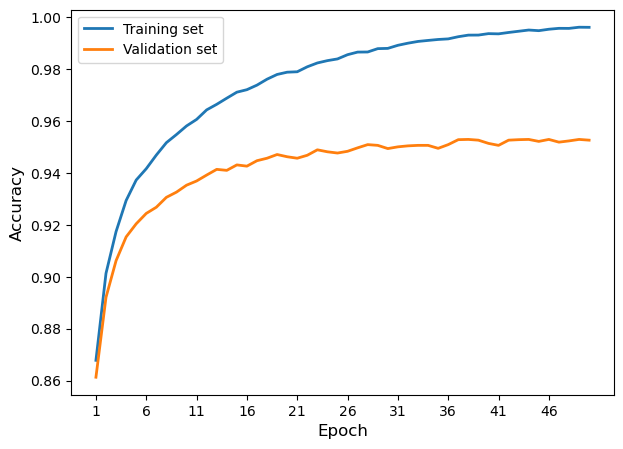

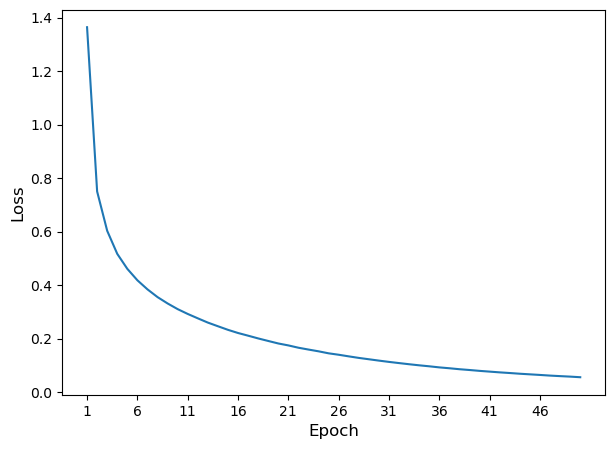

In [42]:
plot_history(train_history_final, validation_history_final, cost_list_final, metric=metric)

In [43]:
test_accuracy_final = model_final.evaluate_on_set(X_test, y_test)
print(f"Test set {metric}: {test_accuracy_final}")

Test set accuracy: 0.9535238095238096


Jak widać, dokładność na zbiorze testowym nie uległa pogorszeniu. Zamiast tego uzyskaliśmy jej zauważalną poprawę, ponieważ wzrosła do ponad **95,35%**, co stanowi najlepszy wynik spośród tych, które uzyskaliśmy do tej pory. Fakt ten potwierdza słuszność naszych dotychczasowych rozważań oraz decyzji dotyczącej zredukowania liczby epok przy danych parametrach.